In [50]:
import os
import sys
import pylab as plt
import numpy as np
from scipy import stats

In [2]:
pwd

'/media/bigdata/projects/pytau/pytau/how_to/examples'

# Download and extract data

In [3]:
LINK_TO_DATA='1s1svxg4CvyUi9eeMzqUbcpiwCtNc170z'

In [4]:
!pip install gdown

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [5]:
!mkdir test_data

mkdir: cannot create directory ‘test_data’: File exists


In [6]:
os.chdir('./test_data')

In [7]:
!gdown {LINK_TO_DATA} -O test_data.zip

Downloading...
From: https://drive.google.com/uc?id=1s1svxg4CvyUi9eeMzqUbcpiwCtNc170z
To: /media/bigdata/projects/pytau/pytau/how_to/examples/test_data/test_data.zip
100%|████████████████████████████████████████| 514k/514k [00:00<00:00, 15.7MB/s]


In [8]:
!unzip test_data.zip

Archive:  test_data.zip
replace AM11_4Tastes_191030_114043_spike_trains_only/AM11_4Tastes_191030_114043_copy.info? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [9]:
!rm test_data.zip

In [10]:
data_dir = os.path.abspath('AM11_4Tastes_191030_114043_spike_trains_only')
print(data_dir)

/media/bigdata/projects/pytau/pytau/how_to/examples/test_data/AM11_4Tastes_191030_114043_spike_trains_only


# Deal with paths

In [14]:
pytau_base_dir = '/media/bigdata/projects/pytau'
sys.path.append(pytau_base_dir)

In [15]:
# Change database save path
!echo {pytau_base_dir}/pytau/how_to/examples/saved_models > {pytau_base_dir}/pytau/config/MODEL_SAVE_DIR.params

# Load Spike Train

In [16]:
import tables
from glob import glob
h5_path = glob(os.path.join(data_dir,'*.h5'))[0]

In [31]:
wanted_dig_in_ind = 0
with tables.open_file(h5_path,'r') as hf5:
    dig_in_list = hf5.list_nodes('/spike_trains')
    wanted_dig_in = dig_in_list[wanted_dig_in_ind]
    spike_train = wanted_dig_in.spike_array[:]

In [32]:
spike_train.shape

(30, 35, 7000)

In [36]:
# Bin Spike Train

In [33]:
from pytau.changepoint_preprocess import preprocess_single_taste

In [34]:
binned_spike_array = preprocess_single_taste(
        spike_array = spike_train, 
        time_lims = [2000,4000],
        bin_width = 50,
        data_transform = None)

In [35]:
binned_spike_array.shape

(30, 35, 40)

# Infer Changepoints

In [39]:
from pytau.changepoint_model import single_taste_poisson, advi_fit

In [42]:
# Create and fit model
n_fit = 40000
n_samples = 20000
n_states = 4
model = single_taste_poisson(binned_spike_array, n_states)
model, approx, lambda_stack, tau_samples, fit_data = \
        advi_fit(model = model, fit = n_fit, samples = n_samples)

Finished [100%]: Average Loss = 22,163


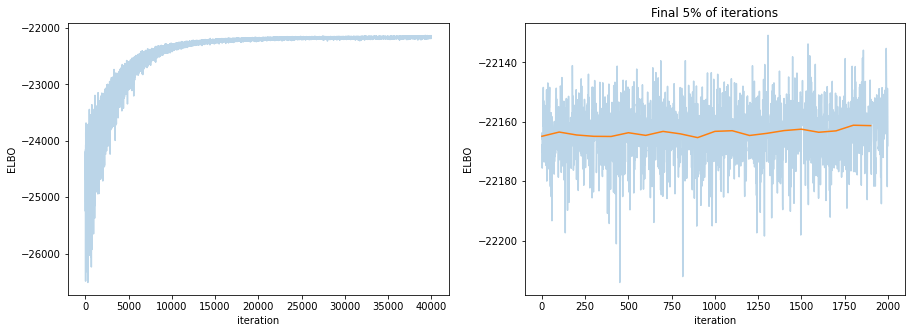

In [47]:
# Plot ELBO over iterations, should be flat by the end
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(n_fit - n_fit*0.05)
last_iters = approx.hist[ind:]
ax[1].plot(-last_iters, alpha=.3)
x = np.arange(len(last_iters))
binned_iters = np.reshape(last_iters, (-1, 100)).mean(axis=-1)
binned_x = x[::100]
ax[1].plot(binned_x, -binned_iters)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

In [51]:
# Extract changepoint values
tau_stack = tau_samples
int_tau = np.vectorize(np.int)(tau_stack)
mode_tau = np.squeeze(stats.mode(int_tau,axis=0)[0])

In [52]:
mode_tau

array([[31, 33, 34],
       [16, 17, 18],
       [12, 26, 26],
       [20, 21, 21],
       [22, 23, 38],
       [ 3, 14, 15],
       [11, 21, 23],
       [12, 18, 20],
       [ 8, 22, 24],
       [12, 29, 32],
       [ 5, 21, 22],
       [ 4, 19, 20],
       [ 8, 11, 13],
       [ 1, 29, 38],
       [16, 18, 38],
       [10, 21, 38],
       [ 5,  7, 27],
       [ 9, 12, 38],
       [ 8, 15, 30],
       [ 7,  9, 38],
       [ 2, 12, 34],
       [ 7, 18, 38],
       [ 1, 13, 22],
       [ 1, 26, 29],
       [18, 20, 34],
       [ 7, 18, 19],
       [ 2, 22, 24],
       [ 1, 31, 36],
       [ 1, 21, 38],
       [ 1, 36, 38]])